# Case Studies 

In the previous tutorials we have introduced the building blocks of IPTK, and how it can be used to analyze different aspects of IP experiments. In the current tutorial,  we are going to put it all togther and reproduce some of the results described in the paper (ElAbd, 2021, manuscript)) through some case studies.

## Import the modules

In [1]:
## First, we import the library modules 
from IPTK.IO.InFunctions import parse_xml_based_format_to_identification_table, download_pdb_entry,parse_text_table
from IPTK.IO.OutFunctions import write_auto_named_peptide_to_fasta 
from IPTK.Utils.UtilityFunction import get_experiment_summary, combine_summary
from IPTK.Classes.Experiment import Experiment
from IPTK.Classes.ExperimentSet import ExperimentSet
from IPTK.Classes.Database import SeqDB, GeneExpressionDB, CellularLocationDB,OrganismDB
from IPTK.Classes.Tissue import Tissue
from IPTK.Classes.HLASet import HLASet
from IPTK.Classes.Proband import Proband
from IPTK.Classes.Peptide import Peptide 
from IPTK.Visualization.vizTools import (plot_parent_protein_expression_in_tissue,plotly_parent_protein_expression_in_tissue, plot_gene_expression_vs_num_peptides, 
plot_num_protein_per_location, plot_num_peptide_per_go_term, plot_overlap_heatmap,plot_protein_coverage,plot_coverage_and_annotation, plot_paired_represention, 
plot_MDS_from_ic_coverage,plotly_multi_traced_coverage_representation)
from IPTK.Analysis.AnalysisFunction import compute_binary_distance, compute_ic_distance_experiments
## second we import common python modules 
import matplotlib.pyplot as plt
from typing import List,Set,Dict 
import pandas as pd 
import numpy as np
import random 
import os
import seaborn as sns
## try to load tqdm and chart_studio and install them if they are not installed  
try: 
    from tqdm import tqdm # print progress information
except ModuleNotFoundError: 
    os.system("pip install tqdm") 
try: 
    import chart_studio.plotly as py 
except ModuleNotFoundError:
    os.system("pip install chart_studio")

## Case study one: Analyzing the differences in HLA-II immunopeptidomes of different tissues

The data is obtained from [HLA ligand atlas](https://hla-ligand-atlas.org/welcome)(Release 2020.06). The data has been processed into tables representing the immunopeptidome of different tissues from one donor, namely, AUT01-DN03. Before we start the analysis, we define some helper functions to help us with loading and parsing the data. 

In [2]:
def load_and_fill_exps_list(path2files:str,res:Dict[str,Experiment], path2seqDB: str):
    """Load the CSV files the generated file object 

    :param path2files: The path to load the CSV files 
    :type path2files: str
    :param res: a list of experimental objects 
    :type res: Dict[str,Experiment]
    :param path2seqDB: the path to the sequence database
    :type  path2seqDB: str 
    """
    # get a list of the CSV file
    file_names: List[str]=get_level_two_subdir(path2files)
    for fname in tqdm(file_names): 
        # generate the tissue name 
        tissue_name: str =fname.split('/')[-1].split('.')[0].split('_')[-1]
        # load the tables as an identification table 
        ident_table: pd.DataFrame = parse_text_table(
            path2file=fname,
            path2fastaDB=path2seqDB,
            seq_column="peptide_seq",
            accession_column="protein_names") 
        # create a proband instance 
        donor: Proband = Proband(name='CLEAVAGE_MOTIF_'+tissue_name) 
        # a place holder for the current usage as we are only interested in the coverage 
        hlas: HLASet = HLASet(hlas=['HLA-DRB1*15:01','HLA-DRB1*13:01']) 
        # generate a sequence database 
        seqs: SeqDB = SeqDB(path2fasta=path2seqDB)
        expresson_profile: GeneExpressionDB= GeneExpressionDB()
        protein_locations: CellularLocationDB= CellularLocationDB()
        # if the tissue is not supported we skip it, i.e. not defined in the expression database 
        try: 
            tissue: Tissue = Tissue(name=tissue_name.lower(),
                        main_exp_value=expresson_profile, 
                        main_location=protein_locations)
        except KeyError:
            print(f'Tissue: {tissue_name} is not on the database')
            continue
        # otherwise we create an experimental instance for this tissue 
        res[tissue_name]=Experiment(
            proband=donor, hla_set=hlas, 
            tissue=tissue, database=seqs, ident_table=ident_table)
        # print progress statment 
        print(f'Tissue: {tissue_name} has been parsed')
    return    
def get_level_two_subdir(path2check: str)->List[str]:
    """List all the directory in a two level path tree 
    """
    results: List[str]= []
    level_one_dirs: List[str] = os.listdir(path2check)
    for dir_ in level_one_dirs: 
        path_=os.path.join(path2check,dir_)
        if os.path.isdir(path_):
            level_two_dirs: List[str] = os.listdir(path_)
            for dir__ in level_two_dirs: 
                results.append(os.path.join(path_,dir__))
    return results

#### Load exps dict by filling the dict of experiments 

In [3]:
## Note: 
#--------------------
# As we do not have access to the exact FASTA file used for generating the peptides we are using the whole Uniprot database, i.e. uniprot_sprot.fasta, to extract sequences #from the database. Unfortunately, this file is about 266MB and could not be uploaded to Github. So, users are encouraged to download this file from Uniprot websites. To #follow along, kindly, download the data from: https://www.uniprot.org/downloads and select Swiss-Prot in a Fasta format.
#--------------------
exps: Dict[str,Experiment] = dict()
load_and_fill_exps_list("atlas_data" ,exps,"/Users/heshamelabd/databases/uniprot_sprot.fasta")

100%|██████████| 17/17 [03:16<00:00, 11.53s/it]Tissue: Testis has been parsed



#### Compute the coverage among different tissues

In [5]:
# Consturct the experiment set 
exp_set: ExperimentSet = ExperimentSet(**exps)

In [23]:
###### Compute the coverage among different tissues
results= dict()
for name in  exp_set.get_experiments().keys():
    results[name]=exp_set[name].get_mapped_protein('P0CG38')
fig=plotly_multi_traced_coverage_representation(results,"Protein Coverage Across ")

py.iplot(fig, filename = 'Protein_Coverage_different_Tissue')

#### Compute peptide overlap among different tissues 

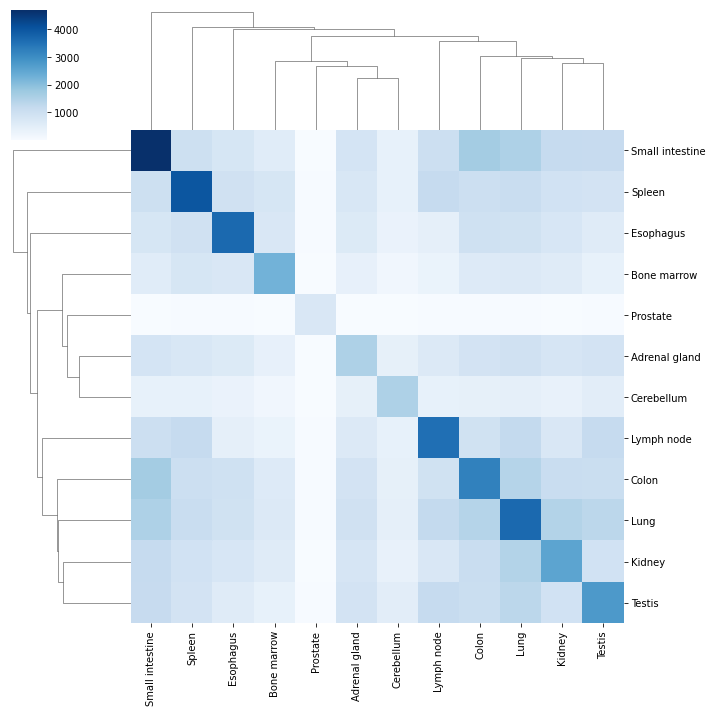

In [25]:
# get the overlap
peptide_overlap: pd.DataFrame =exp_set.compute_peptide_overlap_matrix()
# visualize the results 
fig=plot_overlap_heatmap(peptide_overlap,{'cmap':'Blues'})

#### Compute protein overlap among different tissues 

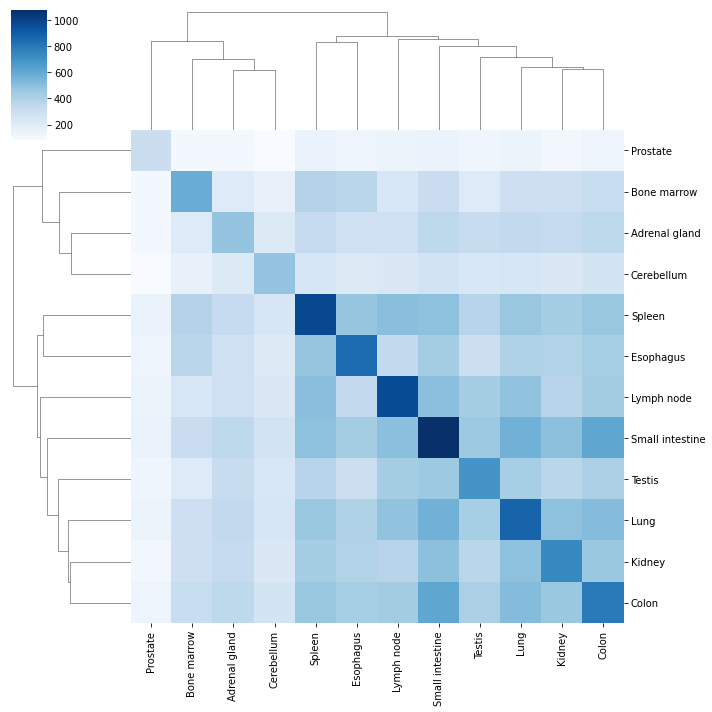

In [27]:
# get the overlap
protein_overlap: pd.DataFrame = exp_set.compute_protein_overlap_matrix()
### 
fig=plot_overlap_heatmap(protein_overlap,{'cmap':'Blues'})

#### Compute immunopeptidomic overlap among different tissues

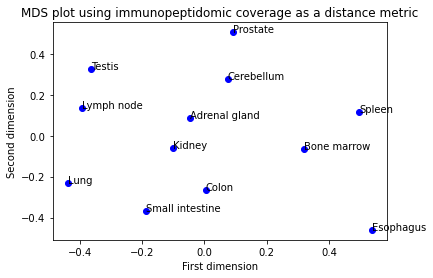

In [6]:
dist_im=compute_ic_distance_experiments(exp_set) ## This might take a couple of minutes 
### visualize the mapping using MDS 
fig=plot_MDS_from_ic_coverage(dist_im)

## Case study two: Combining coverage and UniProt informations

In [56]:
## Load the identification tables 
#--------------------------------
res_one_rep2=parse_xml_based_format_to_identification_table(
    path2XML_file="idXML/27112020_1_all_ids_merged_psm_perc_filtered.idXML",
    path2fastaDB="data/human_proteome.fasta",
    is_idXML= True,
)
## Construct the experimental in-invariants
#------------------------------------------
donor: Proband = Proband(name='Tutorial_2') 
hlas: HLASet = HLASet(hlas=['HLA-DRB1*15:01','HLA-DRB1*13:01'])
seqs: SeqDB = SeqDB(path2fasta="data/human_proteome.fasta")
expresson_profile: GeneExpressionDB= GeneExpressionDB()
protein_locations: CellularLocationDB= CellularLocationDB()
tissue: Tissue = Tissue(name='total PBMC',
                        main_exp_value=expresson_profile, 
                        main_location=protein_locations)
## Define The experiment
#-----------------------
exp_one_rep2= Experiment(proband=donor,hla_set=hlas,tissue=tissue,database=seqs, 
                 ident_table=res_one_rep2)

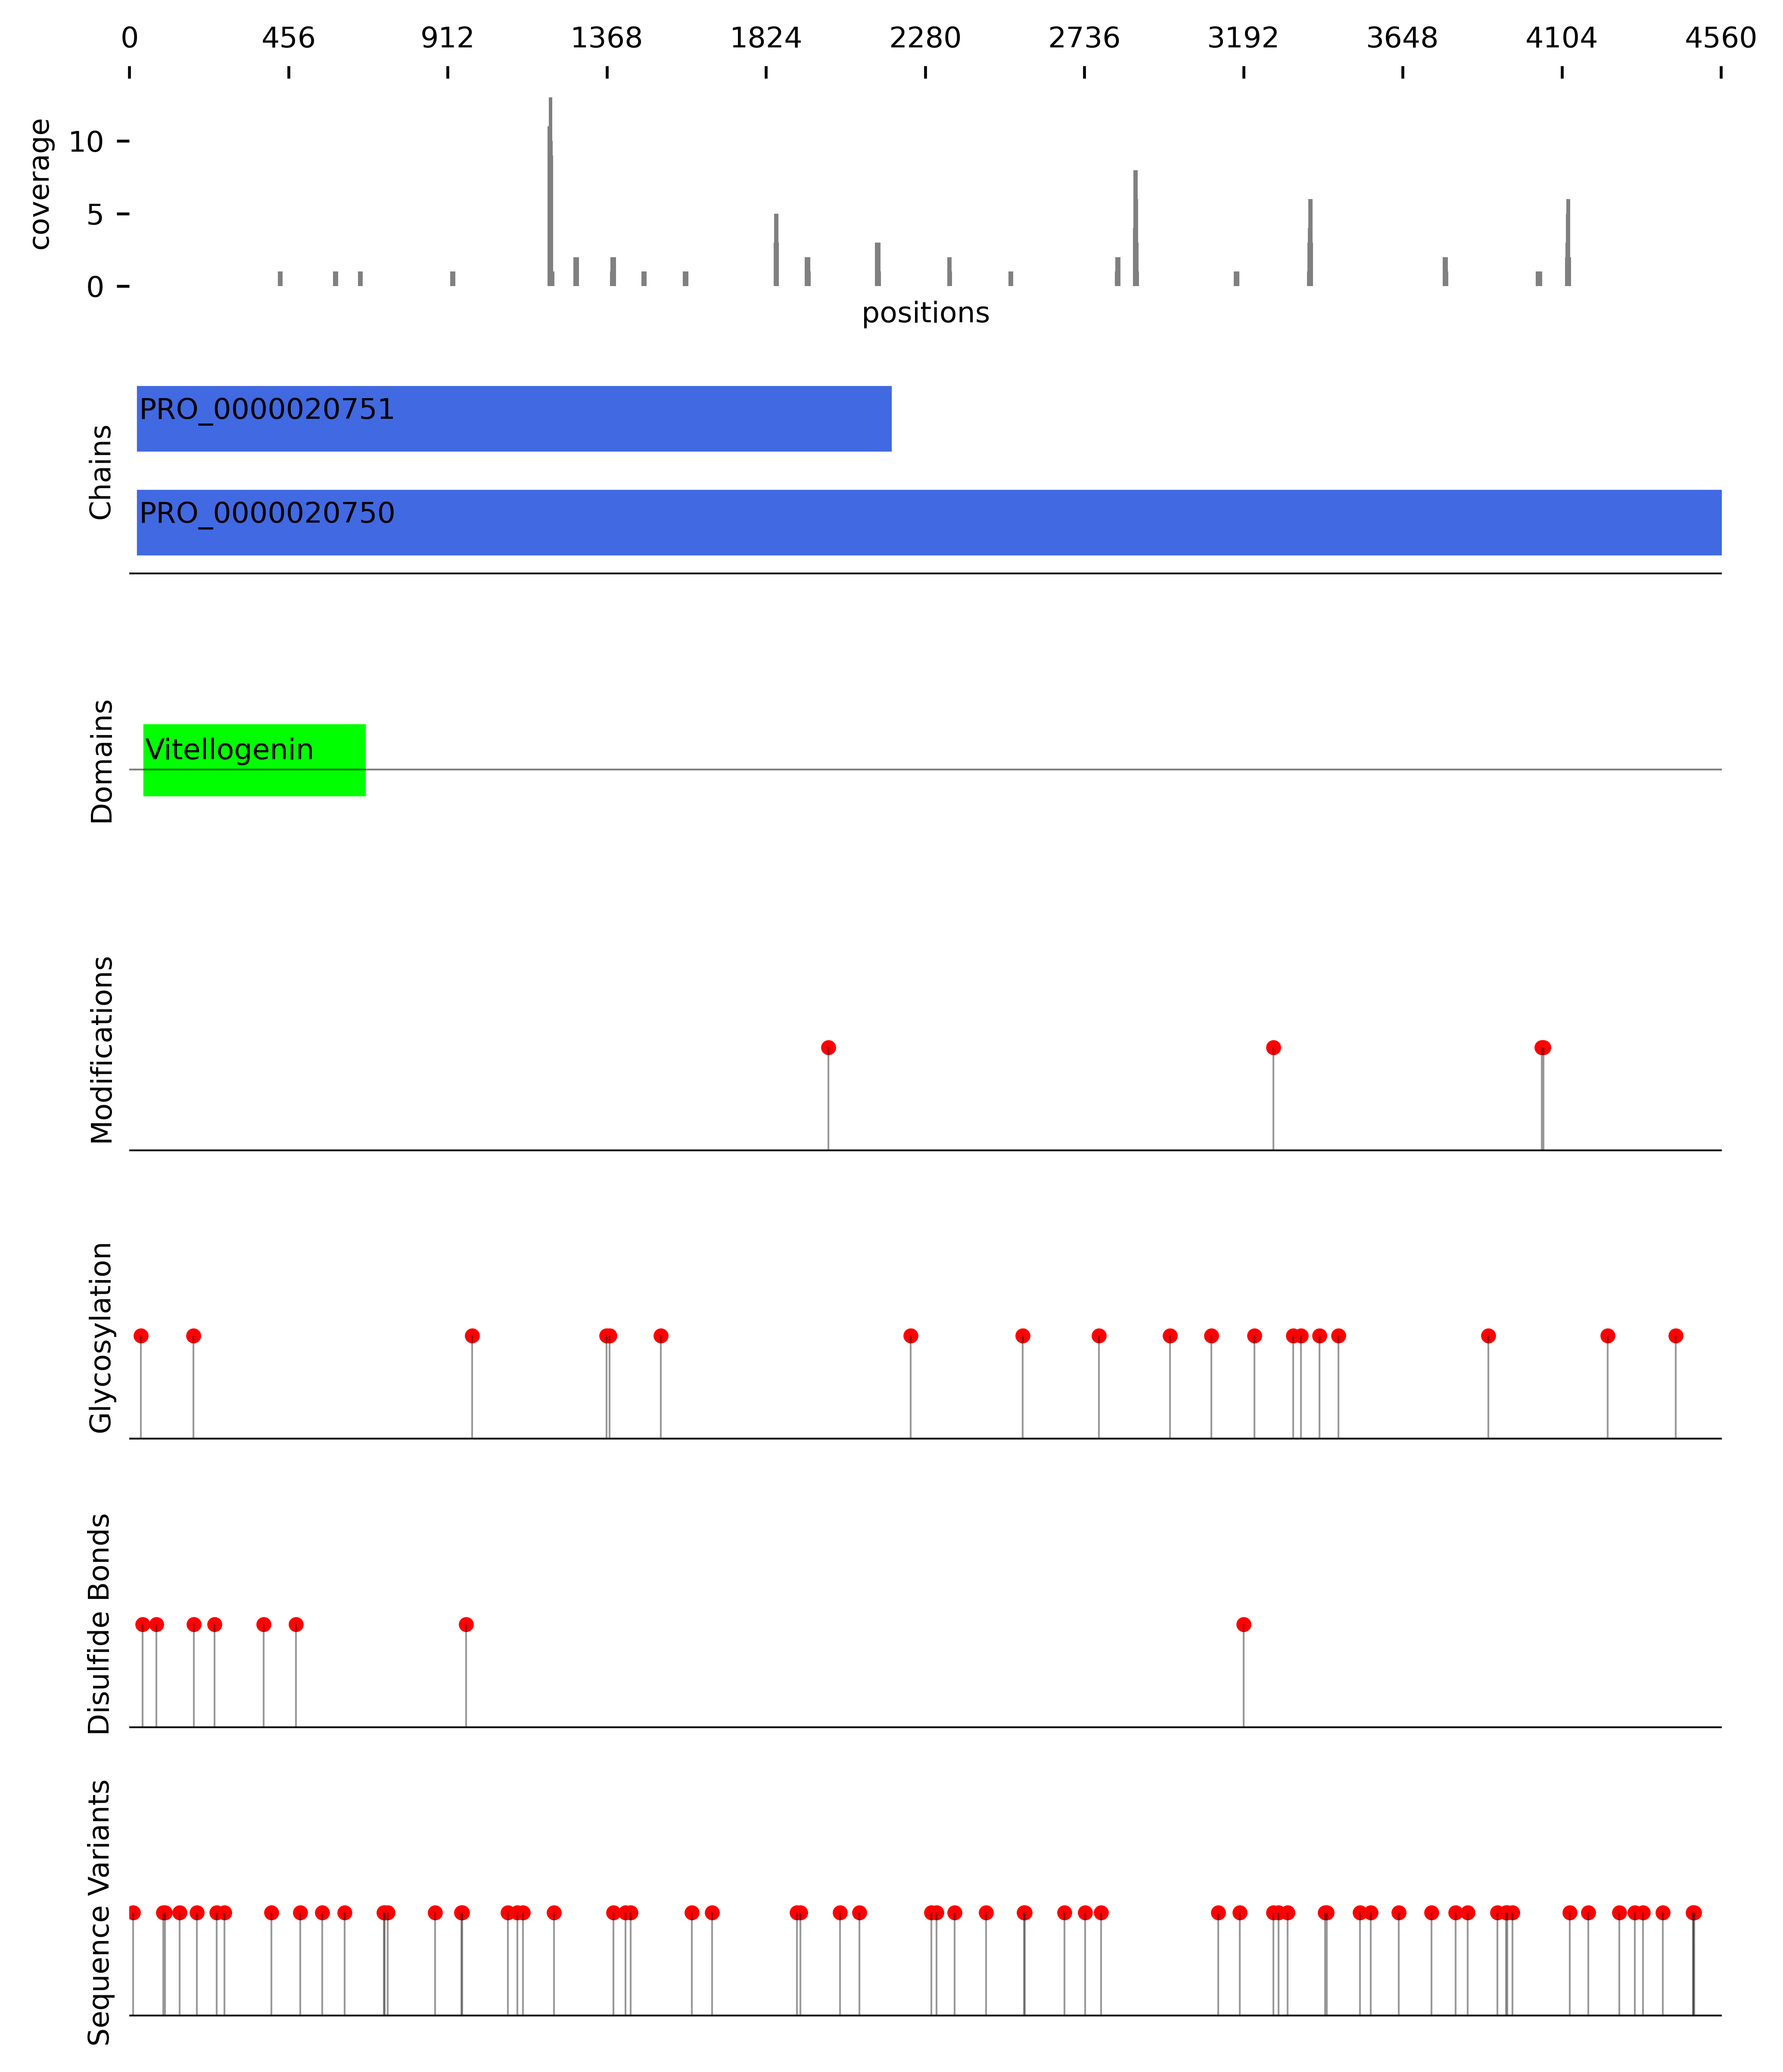

In [57]:
## Generate an annotation and Coverage track
#-------------------------------------------
#### **Note**:
#-------------
# The function needs internet connection to download the XML record from uniprot
#--------
### Compute the coverage arrays
#------------------------------
mapped_coverage=exp_one_rep2.get_mapped_proteins()
###  Get the coverage array for the target protein: P04114
#--------------------------------------------------------- 
P04114_coverage=mapped_coverage['P04114']
### Plot and annotate the protein
#--------------------------------
fig=plot_coverage_and_annotation(
            {'P04114':P04114_coverage.reshape(-1)},
        coverage_track_dict={
            "xlabel_dict":{
                    "fontsize":8
                    },
            "ylabel_dict":{
                                "fontsize":8
                                }, 
                
                "coverage_dict":{
                    "color":"grey",
                    "width":1, 
                },
                "number_ticks":10, 
                "xticks_font_size":8,
                "yticks_font_size":8,
                            },
            chains_track_dict={
                "track_label_dict":{
                                "fontsize":8
                                   }, 
                "track_element_names_dict":{
                                        "fontsize":8
                                            },
                "track_elements_dict":{
                                    "color":"royalblue"
                                        }
                            },
            domain_track_dict={
                "track_label_dict":{
                                "fontsize":8
                                   },
                "track_element_names_dict":{
                                        "fontsize":8
                                        },
                "track_elements_dict":{
                                    "color":"lime"
                                      }
                            },
             modifications_track_dict={
                "track_label_dict":{
                                "fontsize":8
                                   },
                "marker_bar_dict": {
                                "color":"black",
                                "linestyles":"solid",
                                "linewidth":0.5,
                                "alpha":0.4
                                }, 
                "marker_dict":{
                                "s":10,
                                "color":"red"
                             }
                            },
                glyco_track_dict={
                    "track_label_dict":{
                                "fontsize":8
                                   },
                "marker_bar_dict": {
                                "color":"black",
                                "linestyles":"solid",
                                "linewidth":0.5,
                                "alpha":0.4
                                }, 
                "marker_dict":{
                                "s":10,
                                "color":"red"
                             }
                },
                disulfide_track=True,
                disulfide_track_dict={
                    "track_label_dict":{
                                "fontsize":8
                                   },
                "marker_bar_dict": {
                                "color":"black",
                                "linestyles":"solid",
                                "linewidth":0.5,
                                "alpha":0.4
                                }, 
                "marker_dict":{
                                "s":10,
                                "color":"red"
                             }
                }, 
                sequence_variants_track_dict={
                    "track_label_dict":{
                                "fontsize":8
                                   },
                "marker_bar_dict": {
                                "color":"black",
                                "linestyles":"solid",
                                "linewidth":0.5,
                                "alpha":0.4
                                }, 
                "marker_dict":{
                                "s":10,
                                "color":"red"
                             }
                } 
)

In [ ]:
## Finally, we can save the figure for later use using 
fig.savefig('annotation_track.png',dpi=1200)